In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

C:\Users\Amin\AppData\Local\Temp\ipykernel_17864\3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Lab | Natural Language Processing
### SMS: SPAM or HAM

### Let's prepare the environment

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

- Read Data for the Fraudulent Email Kaggle Challenge
- Reduce the training set to speead up development. 

In [3]:
## Read Data for the Fraudulent Email Kaggle Challenge
data = pd.read_csv("../data/kg_train.csv",encoding='latin-1')

# Reduce the training set to speed up development. 
# Modify for final system
data = data.head(1000)
print(data.shape)
data.fillna("",inplace=True)

(1000, 2)


In [4]:
data.head()

,text,label
0,"DEAR SIR, STRICTLY A PRIVATE BUSINESS PROPOSAL...",1
1,Will do.,0
2,Nora--Cheryl has emailed dozens of memos about...,0
3,Dear Sir=2FMadam=2C I know that this proposal ...,1
4,fyi,0


### Let's divide the training and test set into two partitions

In [5]:
# Your code
from sklearn.model_selection import train_test_split

# Split the training data into train and test sets
X = data['text']  # Text features
y = data['label']  # Labels (0=ham, 1=spam)

# Split into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create DataFrames for easier handling
data_train = pd.DataFrame({'text': X_train, 'label': y_train})
data_test = pd.DataFrame({'text': X_test, 'label': y_test})

print(f"Training set size: {data_train.shape}")
print(f"Test set size: {data_test.shape}")
print(f"Class distribution in training set:")
print(f"Ham (0): {(data_train['label'] == 0).sum()}")
print(f"Spam (1): {(data_train['label'] == 1).sum()}")
print(f"Class distribution in test set:")
print(f"Ham (0): {(data_test['label'] == 0).sum()}")
print(f"Spam (1): {(data_test['label'] == 1).sum()}")

Training set size: (800, 2)
Test set size: (200, 2)
Class distribution in training set:
Ham (0): 446
Spam (1): 354
Class distribution in test set:
Ham (0): 112
Spam (1): 88


## Data Preprocessing

In [6]:
import string
from nltk.corpus import stopwords
print(string.punctuation)
print(stopwords.words("english")[100:110])
from nltk.stem.snowball import SnowballStemmer
snowball = SnowballStemmer('english')


!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on']


## Now, we have to clean the html code removing words

- First we remove inline JavaScript/CSS
- Then we remove html comments. This has to be done before removing regular tags since comments can contain '>' characters
- Next we can remove the remaining tags

In [7]:
# Your code
import re
def clean_html(text):
     """Clean HTML tags and content from text"""
     if pd.isna(text):
          return ""
     
     text = str(text)

     # 1. First we remove inline JavaScript/CSS
     text = re.sub(r'<script.*?</script>', '', text, flags=re.DOTALL | re.IGNORECASE)
     text = re.sub(r'<style.*?</style>', '', text, flags=re.DOTALL | re.IGNORECASE)

     # 2. Then we remove html comments (before removing regular tags)
     text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)

     # 3. Next we can remove the remaining tags
     text = re.sub(r'<[^>]+>', '', text)

     # Decode HTML entities
     text = text.replace('&lt;', '<').replace('&gt;', '>').replace('&amp;', '&')
     text = text.replace('=2F', '/').replace('=2C', ',').replace('=3D', '=')
    
     return text

- Remove all the special characters
    
- Remove numbers
    
- Remove all single characters
 
- Remove single characters from the start

- Substitute multiple spaces with single space

- Remove prefixed 'b'

- Convert to Lowercase

In [8]:
def preprocess_text(text):
    """Complete text preprocessing pipeline"""
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # 4. Remove all the special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # 5. Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # 6. Remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # 7. Remove single characters from the start
    text = re.sub(r'^[a-zA-Z]\s+', '', text)
    
    # 8. Substitute multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)
    
    # 9. Remove prefixed 'b'
    text = re.sub(r'^b\s+', '', text)
    
    # 10. Convert to Lowercase
    text = text.lower().strip()
    
    return text

In [9]:
# Apply both functions in sequence: original → HTML cleaned → preprocessed
data_train['preprocessed_text'] = data_train['text'].apply(lambda x: preprocess_text(clean_html(x)))
data_test['preprocessed_text'] = data_test['text'].apply(lambda x: preprocess_text(clean_html(x)))

print("Complete preprocessing pipeline:")
sample_text = data_train['text'].iloc[0]
print(f"Original: {sample_text[:80]}...")
print(f"Final:    {data_train['preprocessed_text'].iloc[0][:80]}...")

Complete preprocessing pipeline:
Original: Dear=2C Good day hope fine=2Cdear am writting this mail with due respect and hea...
Final:    dear good day hope finedear am writting this mail with due respect and heartful ...


## Now let's work on removing stopwords
Remove the stopwords.

In [10]:
# Your code
import nltk
nltk.download('stopwords', quiet=True)

def remove_stopwords(text):
    """Remove stopwords from text"""
    if pd.isna(text) or text == "":
        return ""
    
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    
    return ' '.join(filtered_words)


# Apply stopword removal to both datasets
data_train['preprocessed_text'] = data_train['preprocessed_text'].apply(remove_stopwords)
data_test['preprocessed_text'] = data_test['preprocessed_text'].apply(remove_stopwords)

print("After stopword removal:")
print(f"Sample: {data_train['preprocessed_text'].iloc[0][:80]}...")


After stopword removal:
Sample: dear good day hope finedear writting mail due respect heartful tears since known...


## Tame Your Text with Lemmatization
Break sentences into words, then use lemmatization to reduce them to their base form (e.g., "running" becomes "run"). See how this creates cleaner data for analysis!

In [11]:
# Your code
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)


def lemmatize_text(text):
    """Apply lemmatization to reduce words to their base form"""
    if pd.isna(text) or text == "":
        return ""
    
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(lemmatized_words)

# Apply lemmatization to both datasets
data_train['preprocessed_text'] = data_train['preprocessed_text'].apply(lemmatize_text)
data_test['preprocessed_text'] = data_test['preprocessed_text'].apply(lemmatize_text)

print("After lemmatization:")
print(f"Sample: {data_train['preprocessed_text'].iloc[0][:80]}...")

After lemmatization:
Sample: dear good day hope finedear writting mail due respect heartful tear since known ...


## Bag Of Words
Let's get the 10 top words in ham and spam messages (**EXPLORATORY DATA ANALYSIS**)

In [12]:
# Your code
from collections import Counter
import matplotlib.pyplot as plt

def get_top_words(texts, n=10):
    """Get top n words from a collection of texts"""
    all_words = []
    for text in texts:
        if pd.notna(text) and text != "":
            all_words.extend(text.split())
    
    word_counts = Counter(all_words)
    return word_counts.most_common(n)

# Get top words for ham and spam
ham_texts = data_train[data_train['label'] == 0]['preprocessed_text']
spam_texts = data_train[data_train['label'] == 1]['preprocessed_text']

top_ham_words = get_top_words(ham_texts, 10)
top_spam_words = get_top_words(spam_texts, 10)

print("Top 10 words in HAM messages:")
for word, count in top_ham_words:
    print(f"{word}: {count}")

print("\nTop 10 words in SPAM messages:")
for word, count in top_spam_words:
    print(f"{word}: {count}")

Top 10 words in HAM messages:
would: 91
president: 90
u: 90
percent: 76
call: 75
state: 72
work: 70
mr: 70
one: 62
time: 60

Top 10 words in SPAM messages:
money: 714
account: 603
bank: 572
fund: 543
u: 449
business: 384
transaction: 341
country: 326
million: 315
company: 301


## Extra features

In [13]:
# We add to the original dataframe two additional indicators (money symbols and suspicious words).
money_simbol_list = "|".join(["euro","dollar","pound","€",r"\$"])
suspicious_words = "|".join(["free","cheap","sex","money","account","bank","fund","transfer","transaction","win","deposit","password"])

data_train['money_mark'] = data_train['preprocessed_text'].str.contains(money_simbol_list)*1
data_train['suspicious_words'] = data_train['preprocessed_text'].str.contains(suspicious_words)*1
data_train['text_len'] = data_train['preprocessed_text'].apply(lambda x: len(x)) 

data_test['money_mark'] = data_test['preprocessed_text'].str.contains(money_simbol_list, case=False, na=False)*1
data_test['suspicious_words'] = data_test['preprocessed_text'].str.contains(suspicious_words, case=False, na=False)*1
data_test['text_len'] = data_test['preprocessed_text'].apply(lambda x: len(str(x))) 


data_train.head()

,text,label,preprocessed_text,money_mark,suspicious_words,text_len
442,Dear=2C Good day hope fine=2Cdear am writting ...,1,dear good day hope finedear writting mail due ...,1,1,1009
962,FROM MR HENRY KABORETHE CHIEF AUDITOR INCHARGE...,1,mr henry kaborethe chief auditor inchargeforei...,0,1,1954
971,Will do.,0,,0,0,0
190,FROM THE DESK OF DR.ADAMU ISMALERAUDITING AND...,1,desk dradamu ismalerauditing accounting manage...,1,1,390
551,"Dear Friend, My name is LOI C.ESTRADA,The wife...",1,dear friend name loi cestradathe wife mr josep...,1,1,1507


In [14]:
print("Extra features added:")
print("Training set with extra features:")
print(data_train[['preprocessed_text', 'money_mark', 'suspicious_words', 'text_len', 'label']].head())

print(f"\nFeature statistics:")
print(f"Messages with money symbols: {data_train['money_mark'].sum()}")
print(f"Messages with suspicious words: {data_train['suspicious_words'].sum()}")
print(f"Average text length: {data_train['text_len'].mean():.2f}")

Extra features added:
Training set with extra features:
                                     preprocessed_text  money_mark  \
442  dear good day hope finedear writting mail due ...           1   
962  mr henry kaborethe chief auditor inchargeforei...           0   
971                                                              0   
190  desk dradamu ismalerauditing accounting manage...           1   
551  dear friend name loi cestradathe wife mr josep...           1   

     suspicious_words  text_len  label  
442                 1      1009      1  
962                 1      1954      1  
971                 0         0      0  
190                 1       390      1  
551                 1      1507      1  

Feature statistics:
Messages with money symbols: 232
Messages with suspicious words: 340
Average text length: 928.83


## How would work the Bag of Words with Count Vectorizer concept?

In [15]:
# Your code
from sklearn.feature_extraction.text import CountVectorizer

# Initialize Count Vectorizer
count_vectorizer = CountVectorizer(max_features=5000, stop_words='english')

# Fit and transform the training data
X_train_counts = count_vectorizer.fit_transform(data_train['preprocessed_text'])
X_test_counts = count_vectorizer.transform(data_test['preprocessed_text'])

print(f"Shape of count vectorized training data: {X_train_counts.shape}")
print(f"Shape of count vectorized test data: {X_test_counts.shape}")

# Get feature names
feature_names = count_vectorizer.get_feature_names_out()
print(f"Sample features: {feature_names[:10]}")
print(f"Total features: {len(feature_names)}")

# Show some statistics
print(f"\nVectorization complete!")
print(f"Each email is now represented as a vector of {X_train_counts.shape[1]} features")


Shape of count vectorized training data: (800, 5000)
Shape of count vectorized test data: (200, 5000)
Sample features: ['aae' 'abacha' 'abandoned' 'abedin' 'abidjan' 'abidjancote' 'abilateral'
 'ability' 'able' 'abm']
Total features: 5000

Vectorization complete!
Each email is now represented as a vector of 5000 features


## TF-IDF

- Load the vectorizer

- Vectorize all dataset

- print the shape of the vetorized dataset

In [16]:
# Your code
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit and transform the data
X_train_tfidf = tfidf_vectorizer.fit_transform(data_train['preprocessed_text'])
X_test_tfidf = tfidf_vectorizer.transform(data_test['preprocessed_text'])

print(f"Shape of TF-IDF training data: {X_train_tfidf.shape}")
print(f"Shape of TF-IDF test data: {X_test_tfidf.shape}")

# Show some sample TF-IDF scores
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()
print(f"Sample TF-IDF features: {feature_names_tfidf[:10]}")

print(f"\nTF-IDF vectorization complete!")
print(f"Each email is now represented as a vector of {X_train_tfidf.shape[1]} TF-IDF weighted features")

Shape of TF-IDF training data: (800, 5000)
Shape of TF-IDF test data: (200, 5000)
Sample TF-IDF features: ['aae' 'abacha' 'abandoned' 'abedin' 'abidjan' 'abidjancote' 'abilateral'
 'ability' 'able' 'abm']

TF-IDF vectorization complete!
Each email is now represented as a vector of 5000 TF-IDF weighted features


## And the Train a Classifier?

In [17]:
# Your code
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Train with Count Vectorizer only
nb_counts = MultinomialNB()
nb_counts.fit(X_train_counts, data_train['label'])
y_pred_counts = nb_counts.predict(X_test_counts)
accuracy_counts = accuracy_score(data_test['label'], y_pred_counts)

print("=== Count Vectorizer Results ===")
print(f"Accuracy: {accuracy_counts:.4f}")
print("\nClassification Report:")
print(classification_report(data_test['label'], y_pred_counts, target_names=['Ham', 'Spam']))

# Train with TF-IDF only
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, data_train['label'])
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)
accuracy_tfidf = accuracy_score(data_test['label'], y_pred_tfidf)

print("\n=== TF-IDF Results ===")
print(f"Accuracy: {accuracy_tfidf:.4f}")
print("\nClassification Report:")
print(classification_report(data_test['label'], y_pred_tfidf, target_names=['Ham', 'Spam']))

# Simple comparison
print(f"\n=== Simple Comparison ===")
print(f"Count Vectorizer Accuracy: {accuracy_counts:.4f}")
print(f"TF-IDF Accuracy:          {accuracy_tfidf:.4f}")

if accuracy_tfidf > accuracy_counts:
    print("TF-IDF performs better!")
else:
    print("Count Vectorizer performs better!")

=== Count Vectorizer Results ===
Accuracy: 0.9550

Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.93      0.96       112
        Spam       0.92      0.99      0.95        88

    accuracy                           0.95       200
   macro avg       0.95      0.96      0.95       200
weighted avg       0.96      0.95      0.96       200


=== TF-IDF Results ===
Accuracy: 0.9650

Classification Report:
              precision    recall  f1-score   support

         Ham       0.99      0.95      0.97       112
        Spam       0.94      0.99      0.96        88

    accuracy                           0.96       200
   macro avg       0.96      0.97      0.96       200
weighted avg       0.97      0.96      0.97       200


=== Simple Comparison ===
Count Vectorizer Accuracy: 0.9550
TF-IDF Accuracy:          0.9650
TF-IDF performs better!


=== Count Vectorizer Confusion Matrix ===
Confusion Matrix:
                 Predicted
                 Ham  Spam
Actual    Ham    104     8
          Spam     1    87

=== TF-IDF Confusion Matrix ===
Confusion Matrix:
                 Predicted
                 Ham  Spam
Actual    Ham    106     6
          Spam     1    87


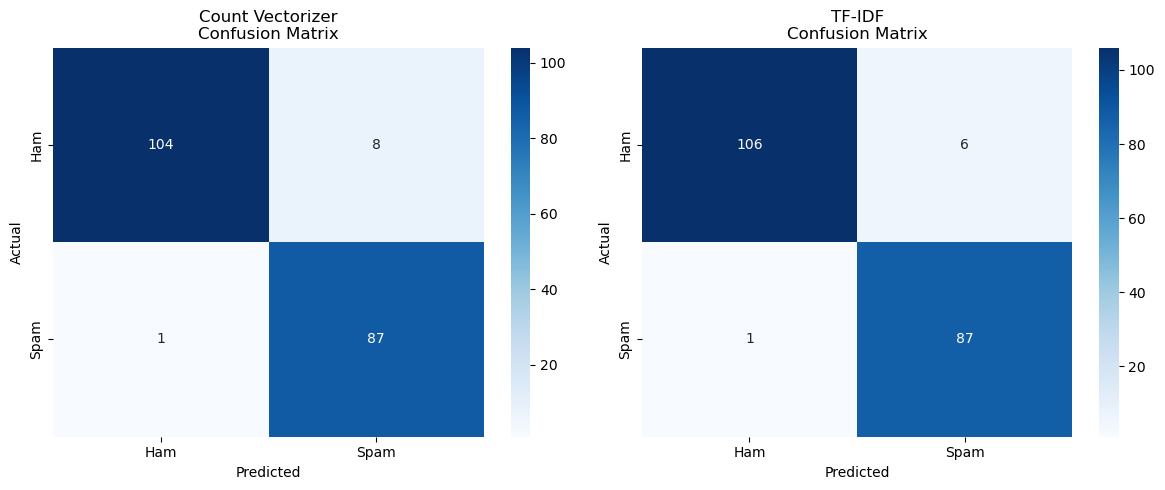


=== Error Analysis ===
Count Vectorizer:
  False Positives (Ham → Spam): 8 emails
  False Negatives (Spam → Ham): 1 emails
TF-IDF:
  False Positives (Ham → Spam): 6 emails
  False Negatives (Spam → Ham): 1 emails


In [18]:
# Confusion matrix analysis
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix for Count Vectorizer
cm_counts = confusion_matrix(data_test['label'], y_pred_counts)
print("=== Count Vectorizer Confusion Matrix ===")
print("Confusion Matrix:")
print(f"                 Predicted")
print(f"                 Ham  Spam")
print(f"Actual    Ham    {cm_counts[0,0]:3d}   {cm_counts[0,1]:3d}")
print(f"          Spam   {cm_counts[1,0]:3d}   {cm_counts[1,1]:3d}")

# Confusion Matrix for TF-IDF
cm_tfidf = confusion_matrix(data_test['label'], y_pred_tfidf)
print("\n=== TF-IDF Confusion Matrix ===")
print("Confusion Matrix:")
print(f"                 Predicted")
print(f"                 Ham  Spam")
print(f"Actual    Ham    {cm_tfidf[0,0]:3d}   {cm_tfidf[0,1]:3d}")
print(f"          Spam   {cm_tfidf[1,0]:3d}   {cm_tfidf[1,1]:3d}")

# Visualize confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Count Vectorizer confusion matrix
sns.heatmap(cm_counts, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'], ax=ax1)
ax1.set_title('Count Vectorizer\nConfusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# TF-IDF confusion matrix
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'], ax=ax2)
ax2.set_title('TF-IDF\nConfusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Analysis of errors
print("\n=== Error Analysis ===")
print("Count Vectorizer:")
print(f"  False Positives (Ham → Spam): {cm_counts[0,1]} emails")
print(f"  False Negatives (Spam → Ham): {cm_counts[1,0]} emails")

print("TF-IDF:")
print(f"  False Positives (Ham → Spam): {cm_tfidf[0,1]} emails")
print(f"  False Negatives (Spam → Ham): {cm_tfidf[1,0]} emails")

### Extra Task - Implement a SPAM/HAM classifier

https://www.kaggle.com/t/b384e34013d54d238490103bc3c360ce

The classifier can not be changed!!! It must be the MultinimialNB with default parameters!

Your task is to **find the most relevant features**.

For example, you can test the following options and check which of them performs better:
- Using "Bag of Words" only
- Using "TF-IDF" only
- Bag of Words + extra flags (money_mark, suspicious_words, text_len)
- TF-IDF + extra flags


You can work with teams of two persons (recommended).

In [ ]:
# Your code